<img src="../../SAR_Training/English/Master/NotebookAddons/blackboard-banner.jpg" width="100%" />
<font face="Calibri">
<br>
<font size="5"> <b>Exploring SAR Data and SAR Time Series Analysis using Jupyter Notebooks</b></font>

<br>
<font size="4"> <b> Franz J Meyer; University of Alaska Fairbanks</b> <br>
<img style="padding:7px;" src="../../SAR_Training/English/Master/NotebookAddons/UAFLogo_A_647.png" width="170" align="right" /></font>

<font size="3">This notebook will allow you to investigate the radar brightness time series of indiviual image pixels in a deep SAR RTC time series stack. The work is done within the framework of *Jupyter Notebooks*. The Jupyter Notebook environment is easy to launch in any web browser for interactive data exploration with provided or new training data. Notebooks are comprised of text written in a combination of executable python code and markdown formatting including latex style mathematical equations. Another advantage of Jupyter Notebooks is that they can easily be expanded, changed, and shared with new data sets or newly available time series steps. Therefore, they provide an excellent basis for collaborative and repeatable data analysis. <br>

<b>We introduce the following data analysis concepts:</b>

- How to load your own SAR data into Jupyter Notebooks and create a time series stack 
- How to apply calibration constants to covert initial digital number (DN) data into calibrated radar cross section information.
- How to subset images and create a time series of your subset data.
- How to explore the time-series information in SAR data stacks for environmental analysis.


</font>

<hr>
<font face="Calibri" size="5" color='rgba(200,0,0,0.2)'> <b>Important Notes about JupyterHub</b> </font>
<br><br>
<font face="Calibri" size="3"> <b>Your JupyterHub server will automatically shutdown when left idle for more than 1 hour. Your notebooks will not be lost but you will have to restart their kernels and re-run them from the beginning. You will not be able to seamlessly continue running a partially run notebook.</b> </font>
<br><br>
</font>


<hr>
<font face="Calibri">

<font size="5"> <b> 0. Importing Relevant Python Packages </b> </font>

<font size="3">In this notebook we will use the following scientific libraries:

<ol type="1">
    <li> <b><a href="https://pandas.pydata.org/" target="_blank">Pandas</a></b> is a Python library that provides high-level data structures and a vast variety of tools for analysis. The great feature of this package is the ability to translate rather complex operations with data into one or two commands. Pandas contains many built-in methods for filtering and combining data, as well as the time-series functionality. </li>
    <li> <b><a href="https://www.gdal.org/" target="_blank">GDAL</a></b> is a software library for reading and writing raster and vector geospatial data formats. It includes a collection of programs tailored for geospatial data processing. Most modern GIS systems (such as ArcGIS or QGIS) use GDAL in the background.</li>
    <li> <b><a href="http://www.numpy.org/" target="_blank">NumPy</a></b> is one of the principal packages for scientific applications of Python. It is intended for processing large multidimensional arrays and matrices, and an extensive collection of high-level mathematical functions and implemented methods makes it possible to perform various operations with these objects. </li>
    <li> <b><a href="https://matplotlib.org/index.html" target="_blank">Matplotlib</a></b> is a low-level library for creating two-dimensional diagrams and graphs. With its help, you can build diverse charts, from histograms and scatterplots to non-Cartesian coordinates graphs. Moreover, many popular plotting libraries are designed to work in conjunction with matplotlib. </li>
</font>

In [17]:
# Check Python version:
import sys
pn = sys.version_info[0]

import os # for chdir, getcwd, path.basename, path.exists
os.environ["PROJ_LIB"] = '/opt/conda/share/proj/'
import glob # for glob
import json # for loads
import math # for ceil
try:
    from osgeo import gdal # for Info
except:
    import gdal

import pandas as pd # for DatetimeIndex
import numpy as np #for log10, mean, percentile, power
import matplotlib.pylab as plb # for add_patch, add_subplot, figure, hist, imshow, set_title, xaxis,_label, text 
import matplotlib.pyplot as plt # for add_subplot, axis, figure, imshow, legend, plot, set_axis_off, set_data,
                                # set_title, set_xlabel, set_ylabel, set_ylim, subplots, title, twinx
import matplotlib.patches as patches  # for Rectangle
import matplotlib.animation as an # for FuncAnimation
from matplotlib import rc 

from asf_notebook import path_exists
from asf_notebook import asf_unzip
from asf_notebook import new_directory

from IPython.display import HTML
plt.rcParams.update({'font.size': 12})


import pyproj
import copy
from datetime import datetime
import subprocess, sys
from math import ceil

if pn == 2:
    import cStringIO #needed for the image checkboxes
elif pn == 3:
    import io
    import base64

# For exporting:
from PIL import Image

<font face="Calibri" size="3"><b>Setup matplotlib plotting inside the notebook:</b></font>

In [4]:
%matplotlib notebook

<hr>
<font face="Calibri">

<font size="5"> <b> 1. Load Your Prepared Data Stack Into the Notebook </b> </font> 

<font size="3"> This notebook assumes that you've prepared your own data stack of <b>RTC image products</b> over your personal area of interest. This can be done using the <b>Prepare_Data_Stack_Hyp3</b> and <b>Subset_Data_Stack notebooks</b>.
    
This notebook expects <a href="https://media.asf.alaska.edu/uploads/RTC/rtc_atbd_v1.2_final.pdf" target="_blank">Radiometric Terrain Corrected</a> (RTC) image products as input, so be sure to select an RTC process when creating the subscription for your input data within HyP3. Prefer a **unique orbit geometry** (ascending or descending) to keep geometric differences between images low. 

<b>Begin by writing a function to retrieve and the absolute paths to each of our tiffs:</b>
</font> 
</font>

In [5]:
def get_tiff_paths(paths):
    tiff_paths = !ls $paths | sort -t_ -k5,5
    return tiff_paths

<font face="Calibri" size="3"><b>Enter the path to the directory holding your tiffs:</b> </font>

In [6]:
while True:
    print("Enter the absolute path to the directory holding your tiffs.")
    tiff_dir = input()
    paths = f"{tiff_dir}/*.tiff"
    if os.path.exists(tiff_dir):
        tiff_paths = get_tiff_paths(paths)
        if len(tiff_paths) < 1:
            print(f"{tiff_dir} exists but contains no tifs.")
            print("You will not be able to proceed until tifs are prepared.")
        break
    else:
        print(f"\n{tiff_dir} does not exist.")
        continue

Enter the absolute path to the directory holding your tiffs.
/Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer


<font face="Calibri" size="3"><b>Determine the path to the analysis directory containing the tiff directory:</b> </font>

In [7]:
analysis_dir = os.path.dirname(tiff_dir)
print(analysis_dir)

/Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data


<font face="Calibri" size="3"><b>Create a wildcard path to the tiffs (in VV polarity):</b> </font>

In [8]:
wildcard_path = f"{tiff_dir}/*.tiff"
print(wildcard_path)

/Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer/*.tiff


<font face="Calibri" size="3"><b>Write a function to extract the tiff dates from a wildcard path:</b> </font>

In [9]:
def get_dates(paths):
    dates = []
    pths = glob.glob(paths)
    for p in pths:
        date = p.split('/')[-1].split("_")[0]
        dates.append(date)
    dates.sort()
    return dates

<font face="Calibri" size="3"><b>Call get_dates() to collect the product acquisition dates:</b></font>

In [10]:
dates = get_dates(wildcard_path)
print(dates)

['20180619', '20180619', '20180623', '20180623', '20180701', '20180701', '20180705', '20180705', '20180713', '20180713', '20180717', '20180717', '20180725', '20180725', '20180729', '20180729', '20180806', '20180806', '20180810', '20180810']


<font face="Calibri" size="3"><b>Gather the upper-left and lower-right corner coordinates of the data stack:</b></font>

In [12]:
coords = [[], []]
info = (gdal.Info(tiff_paths[0], options = ['-json']))
info = json.dumps(info)
coords[0] = (json.loads(info))['cornerCoordinates']['upperLeft']
coords[1] = (json.loads(info))['cornerCoordinates']['lowerRight']
print(coords)

[[607860.0, 1724130.0], [768060.0, 1591740.0]]


<font face="Calibri" size="3"><b>Grab the stack's UTM zone.</b> Note that any UTM zone conflicts should already have been handled in the Prepare_Data_Stack_Hyp3 notebook.</font>

In [13]:
info = (json.loads(info))['coordinateSystem']['wkt']
utm = info[(len(info)-8):(len(info)-3)]
print(f"UTM Zone: {utm}")

UTM Zone: ,3264


<br>
<font face="Calibri" size="5"> <b> 2. Create the VRT </b> </font> 
<br><br>
<font face="Calibri" size="3"><b>Parse the polarization from a tiff name and define a path to the vrt:</b></font>

In [14]:
polarization = get_tiff_paths(wildcard_path)[0].split('.')[-2][-2:]
print(polarization)
raster_path = f"{analysis_dir}/raster_stack_{polarization}.vrt"

VH


<font face="Calibri" size="3"><b>Create the virtual raster table for the GeoTiffs:</b></font>

In [15]:
!gdalbuildvrt -separate $raster_path $wildcard_path

0...10...20...30...40...50...60...70...80...90...100 - done.


<font face="Calibri" size="3"><b>Create Pandas time index:</b> and print the dates</font>

In [16]:
time_index = pd.DatetimeIndex(dates)

for jacqdate, acqdate in enumerate(time_index):
    print('{:4d} {}'.format(jacqdate, acqdate.date()),end=' ')
    if (jacqdate % 5 == 4): print()

   0 2018-06-19    1 2018-06-19    2 2018-06-23    3 2018-06-23    4 2018-07-01 
   5 2018-07-01    6 2018-07-05    7 2018-07-05    8 2018-07-13    9 2018-07-13 
  10 2018-07-17   11 2018-07-17   12 2018-07-25   13 2018-07-25   14 2018-07-29 
  15 2018-07-29   16 2018-08-06   17 2018-08-06   18 2018-08-10   19 2018-08-10 


<br>
<hr>
<font face="Calibri" size="5"> <b> 3. Data exploration with an animation </b> </font> 


<font face="Calibri" size="3"><b>Read the data</b></font>

In [18]:
img = gdal.Open(raster_path)
band = img.GetRasterBand(1)
raster0 = band.ReadAsArray()
band_number = 0 # Needed for updates
rasterstack = img.ReadAsArray()
rs2 = np.ma.masked_where(rasterstack==0, rasterstack)

<font face="Calibri" size="3">Before analyzing the data, decide whether to use <b>linear or logarithmic scaling</b></font>

In [19]:
use_dB = True

def convert(raster, use_dB=use_dB):
    # some Python trickery: 
    # if you call the convert function later, you can set the keyword 
    # argument use_dB to True or False
    # if you do not provide a keyword argument, the value that you set
    # above (when defining the function) is used
    if use_dB:
        return 10 * np.log10(raster)
    else:
        return raster


<font face="Calibri" size="3"> Let's create an <b>animation</b> to get an idea of where and when flooding might have occurred.</font>

In [20]:
%%capture 
figani = plt.figure(figsize=(10, 5))
axani = figani.subplots()
axani.axis('off')

rasterstack_ = convert(rs2)

imani = axani.imshow(rasterstack_[0,...], cmap='gray', vmin=np.nanpercentile(rasterstack_, 1), 
               vmax=np.nanpercentile(rasterstack_, 99))
axani.set_title("{}".format(time_index[0].date()))

def animate(i):
    axani.set_title("{}".format(time_index[i].date()))
    imani.set_data(rasterstack_[i,...])

# Interval is given in milliseconds
ani = an.FuncAnimation(figani, animate, frames=rasterstack_.shape[0], interval=300)
rc('animation', embed_limit=40971520.0)  # We need to increase the limit maybe to show the entire animation

<font face="Calibri" size="3"><b>Render</b></font>

In [21]:
HTML(ani.to_jshtml())

<br>
<div class="alert alert-success">
<font face="Calibri" size="5"> <b> <font color='rgba(200,0,0,0.2)'> <u>EXERCISE</u>:  </font> Backscatter dynamics</b> </font>

<font face="Calibri" size="3"> What is the most striking change in February 2017? Can you explain why the backscatter changes the way it does during that period?
</font>
</div>


<hr>
<br>
<font face="Calibri" size="5"> <b> 4. Create Minimum Image to Identify Inundated Areas </b> </font>
<br><br>
<font face="Calibri" size="3"> As flooding is often associated with very low backscater, we first compute the minimum backscatter for each pixel to get a first impression of areas that could have been flooded during the entire period. </font>


<font face="Calibri" size="3"> The following line <b>calculates the minimum backscatter per pixel</b> across the time series: </font>

In [22]:
temporal_min = np.nanmin(convert(rs2), axis=0)

/Users/biplovbhandari/miniconda3/envs/sar_uaf/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


<br>
<font face="Calibri" size="4"> <b> 4.2 Visualize the Minimum Image with Curser Information Included </b> </font>

<font face="Calibri" size="3"> We will now visualize the minimum image in a way that we can move our mouse over the image and visualize the line/sample image coordinates. This will help us create time-series information for the most interesting image locations. 
    
To do so, we <b>first create some helper functions:</b>
</font> 

In [23]:
class pixelPicker:
    def __init__(self, image, width, height):
        self.x = None
        self.y = None
        self.fig = plt.figure(figsize=(width, height))
        self.ax = self.fig.add_subplot(111, visible=False)
        self.rect = patches.Rectangle(
            (0.0, 0.0), width, height, 
            fill=False, clip_on=False, visible=False
        )
       
        self.rect_patch = self.ax.add_patch(self.rect)
        self.cid = self.rect_patch.figure.canvas.mpl_connect('button_press_event', 
                                                             self)
        self.image = image
        self.plot = self.gray_plot(self.image, fig=self.fig, return_ax=True)
        self.plot.set_title('Select a Point of Interest')
        
        
    def gray_plot(self, image, vmin=None, vmax=None, fig=None, return_ax=False):
        '''
        Plots an image in grayscale.
        Parameters:
        - image: 2D array of raster values
        - vmin: Minimum value for colormap
        - vmax: Maximum value for colormap
        - return_ax: Option to return plot axis
        '''
        if vmin is None:
            vmin = np.nanpercentile(self.image, 1)
        if vmax is None:
            vmax = np.nanpercentile(self.image, 99)
        if fig is None:
           my_fig = plt.figure() 
        ax = fig.add_axes([0.1,0.1,0.8,0.8])
        ax.imshow(image, cmap=plt.cm.gist_gray, vmin=vmin, vmax=vmax)
        if return_ax:
            return(ax)
        
    
    def __call__(self, event):
        print('click', event)
        self.x = event.xdata
        self.y = event.ydata
        for pnt in self.plot.get_lines():
            pnt.remove()
        plt.plot(self.x, self.y, 'ro')


<font face="Calibri" size="3"> Now we are ready to plot the minimum image. <b>Click a point interest for which you want to analyze radar brightness over time</b>: </font>

<IPython.core.display.Javascript object>


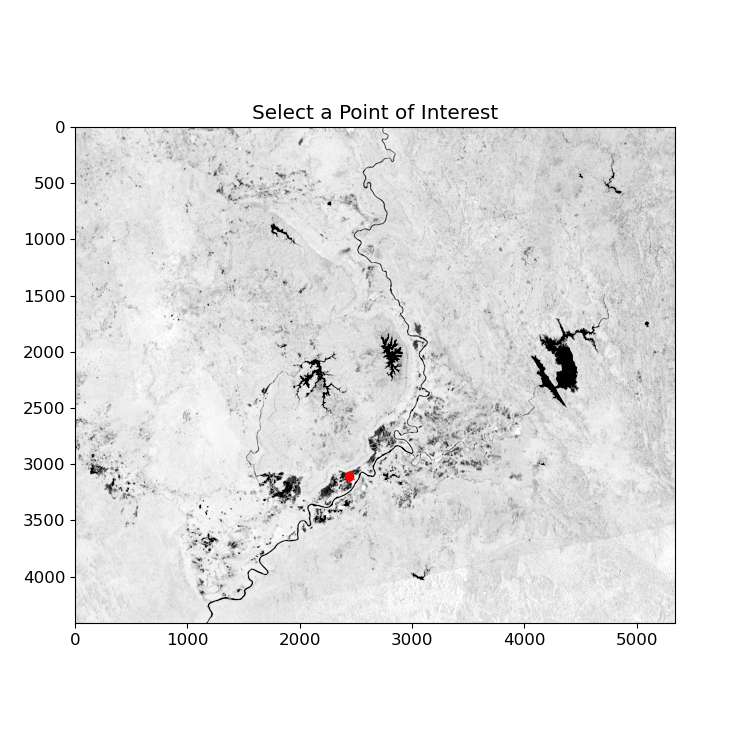

In [24]:
fig_xsize = 7.5
fig_ysize = 7.5
my_plot = pixelPicker(temporal_min, fig_xsize, fig_ysize)

<font face="Calibri" size="3"><b>Save the selected coordinates</b>: </font>

In [29]:
sarloc = (ceil(my_plot.x), ceil(my_plot.y))
print(sarloc)

(2436, 3104)


<br>
<font face="Calibri" size="5"> <b> 5. Plot SAR Brightness Time Series at Point Locations </b> </font>

<font face="Calibri" size="4"> <b> 5.1 SAR Brightness Time Series at Point Locations </b> </font>

<font face="Calibri" size="3"> We will pick a pixel location identified in the SAR image above and plot the time series for this identified point. By focusing on image locations undergoing deforestation, we should see the changes in the radar cross section related to the deforestation event.
    
First, for processing of the imagery in this notebook we generate a list of image handles and retrieve projection and georeferencing information. We also define a function for mapping image pixels to a geographic projection</font> 

In [30]:
geotrans = img.GetGeoTransform()
proj = img.GetProjection()
xsize = img.RasterXSize
ysize = img.RasterYSize
bands = img.RasterCount
projlatlon = pyproj.Proj('+init=EPSG:4326') # WGS84
projstring = proj.split('[')[-1][:-2].split(',')[-1][1:-1]
projimg = pyproj.Proj(f'+init=EPSG:{projstring}')

def geolocation(x, y=None, latlon=True):
    if len(x) == 2:
        y = x[1]
        x = x[0]
    ref_x=geotrans[0]+sarloc[0]*geotrans[1]
    ref_y=geotrans[3]+sarloc[1]*geotrans[5]
    if latlon:
        ref_y, ref_x = pyproj.transform(projimg, projlatlon, ref_x, ref_y)
    return (ref_x, ref_y)

/Users/biplovbhandari/miniconda3/envs/sar_uaf/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/Users/biplovbhandari/miniconda3/envs/sar_uaf/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


<font face="Calibri" size="3"> Now, let's <b>pick a rectangle around a center pixel which we selected and defined in variable <i>sarloc</i></b>...</font>

In [31]:
extent = (5, 5) # choose a 5 by 5 rectangle
latlon = True # if False: return utm coordinates

refsarloc = geolocation(sarloc, latlon=latlon)
projsymbol = '°' if latlon else 'm'

/Users/biplovbhandari/miniconda3/envs/sar_uaf/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


<font face="Calibri" size="3">... and <b>extract the time series</b> for this small area around the selected center pixel in a memory-efficient way (needed for larger stacks):</font> 

<IPython.core.display.Javascript object>


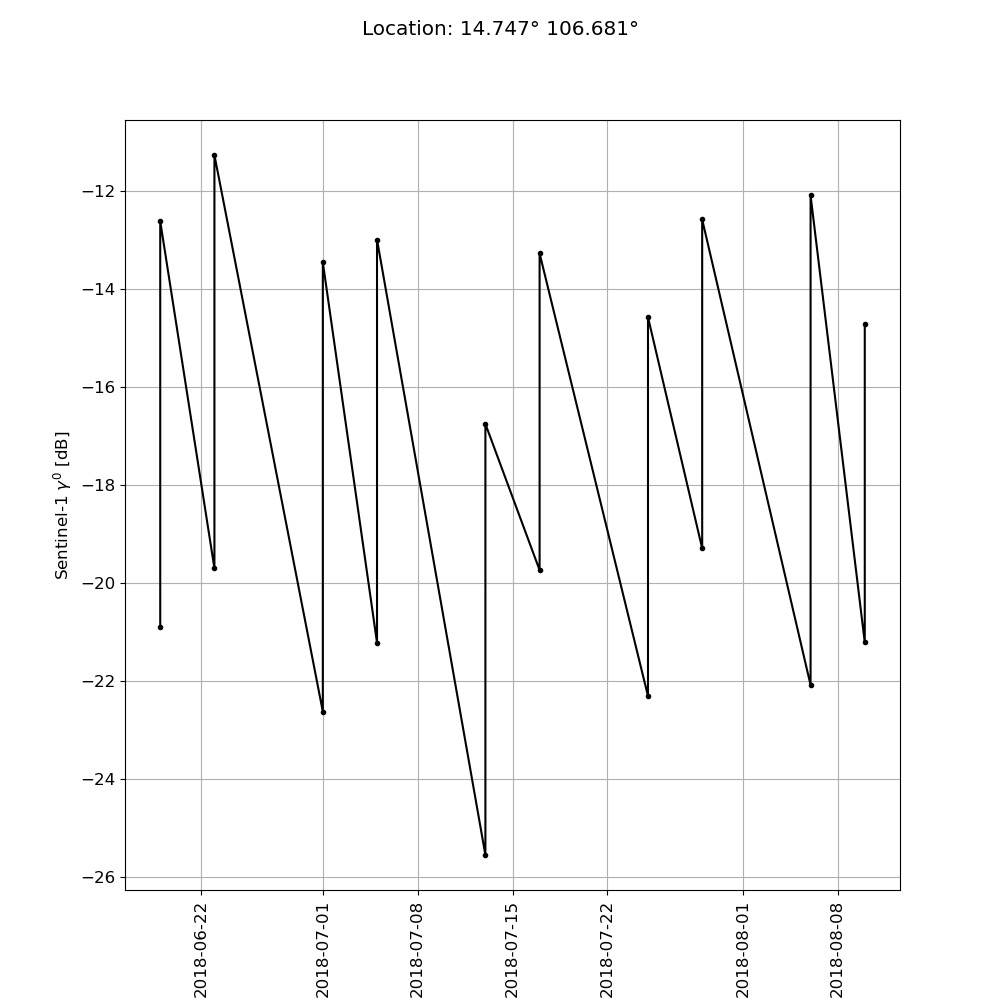

In [43]:
bs_aggregated = []
for band in range(bands):
    rs = img.GetRasterBand(band+1).ReadAsArray(sarloc[0], sarloc[1], 
                                               extent[0], extent[1])
    rs_mean = convert(np.nanmean(rs))
    bs_aggregated.append(rs_mean)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
labeldB = 'dB' if use_dB else 'linear'
ax.plot(time_index, bs_aggregated, color='k', marker='o', markersize=3)
plt.xticks(rotation=90)
ax.set_xlabel('Date')
ax.set_ylabel(f'Sentinel-1 $\gamma^0$ [{labeldB}]')

plt.grid()
_ = fig.suptitle(f'Location: {refsarloc[0]:.3f}{projsymbol} '
                 f'{refsarloc[1]:.3f}{projsymbol}')

# fig.tight_layout() 
figname = (f'RCSTimeSeries-{refsarloc[0]:.3f}{projsymbol} '
           f'{refsarloc[1]:.3f}{projsymbol}.png')
plt.savefig(figname, dpi=300, transparent='true')

<br>
<div class="alert alert-success">
<font face="Calibri" size="5"> <b> <font color='rgba(200,0,0,0.2)'> <u>EXERCISE</u>:  </font> Explore Time Series at Different Point Locations </b> </font>

<font face="Calibri" size="3"> Can you interpret and attribute the changes at various locations? Apart from the flooding, what other patterns do you observe?
</font>
</div>
<br>
<hr>

<font face="Calibri" size="2"> <i>SAR Training Materials - Version 1.1 - October 2019 </i>
</font>